<a href="https://colab.research.google.com/github/mateuspalacio/grupo_four_jupyter/blob/main/AV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix,r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from math import sqrt
from datetime import date, timedelta
%tensorflow_version 2.x
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive/')

from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

transformar_features = True

import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import multiprocessing as mp

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [3]:
tf.test.gpu_device_name()

''

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
path = os.path.join('VendasTesouroDireto_1.json')
values = pd.read_json(path)
df_data = pd.DataFrame(values)
df_data['Tipo_Titulo'] = df_data['Tipo_Titulo'].astype('str') 
df_data['PU'] = df_data['PU'].str.replace(',', '.')
df_data['Quantidade'] = df_data['Quantidade'].str.replace(',', '.')
df_data['Valor'] = df_data['Valor'].str.replace(',', '.')
df_data['PU'] = pd.to_numeric(df_data['PU'],errors='coerce')
df_data['Quantidade'] = pd.to_numeric(df_data['Quantidade'], errors='coerce')
df_data['Valor'] = pd.to_numeric(df_data['Valor'], errors='coerce')

df_data['Vencimento_do_Titulo'] = pd.to_datetime(df_data['Vencimento_do_Titulo'],errors='coerce',dayfirst=True)
 
df_data['Data_Venda'] = pd.to_datetime(df_data['Data_Venda'],errors='coerce', dayfirst=True)

df_data

,Tipo_Titulo,Vencimento_do_Titulo,Data_Venda,PU,Quantidade,Valor
0,Tesouro IPCA+ com Juros Semestrais,2012-08-15,2008-12-05,1655.206735,38.6,63890.97
1,Tesouro IPCA+ com Juros Semestrais,2017-05-15,2008-12-05,1480.154343,571.0,845168.12
2,Tesouro Prefixado com Juros Semestrais,2014-01-01,2008-12-05,870.303177,283.2,246469.85
3,Tesouro Prefixado com Juros Semestrais,2012-01-01,2008-12-05,936.285273,29.2,27339.52
4,Tesouro Prefixado com Juros Semestrais,2017-01-01,2008-12-05,808.587250,491.8,397663.20
...,...,...,...,...,...,...
66164,Tesouro Prefixado com Juros Semestrais,2010-01-01,2008-08-27,960.339019,110.2,105829.35
66165,Tesouro IPCA+ com Juros Semestrais,2010-08-15,2008-08-27,1672.613421,271.2,453612.75
66166,Tesouro IPCA+ com Juros Semestrais,2011-05-15,2008-08-27,1677.517573,88.2,147957.04
66167,Tesouro Prefixado com Juros Semestrais,2010-07-01,2008-08-27,946.566666,0.6,567.93


In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66169 entries, 0 to 66168
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Tipo_Titulo           66169 non-null  object        
 1   Vencimento_do_Titulo  66169 non-null  datetime64[ns]
 2   Data_Venda            66169 non-null  datetime64[ns]
 3   PU                    66169 non-null  float64       
 4   Quantidade            66169 non-null  float64       
 5   Valor                 66169 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 3.0+ MB


In [7]:
aux=df_data.drop(columns=['Vencimento_do_Titulo','PU','Quantidade'])
aux.set_index('Data_Venda')
data_Value_Per_Day_Selic=pd.DataFrame(aux[aux['Tipo_Titulo']=='Tesouro Selic'].groupby(aux['Data_Venda'].dt.to_period('d'))['Valor'].sum())
data_Value_Per_Day_Selic

,Valor
Data_Venda,
2002-01-07,15248.32
2002-01-08,42581.98
2002-01-09,7840.74
2002-01-10,252.18
2002-01-11,6315.69
...,...
2021-08-05,51618710.69
2021-08-06,64518858.59
2021-08-09,65513084.83


In [8]:
aux=df_data.drop(columns=['Vencimento_do_Titulo','PU','Valor'])
aux.set_index('Data_Venda')
data_Amount_Per_Day_Selic=pd.DataFrame(aux[aux['Tipo_Titulo']=='Tesouro Selic'].groupby(aux['Data_Venda'].dt.to_period('d'))['Quantidade'].sum())
data_Amount_Per_Day_Selic

,Quantidade
Data_Venda,
2002-01-07,12.20
2002-01-08,33.80
2002-01-09,6.20
2002-01-10,0.20
2002-01-11,5.00
...,...
2021-08-05,4765.41
2021-08-06,5953.69
2021-08-09,6044.49


In [9]:
data_day = data_Amount_Per_Day_Selic.merge(data_Value_Per_Day_Selic,on='Data_Venda')
data_day['Data_Venda'] = data_day.index
data_day

,Quantidade,Valor,Data_Venda
Data_Venda,,,
2002-01-07,12.20,15248.32,2002-01-07
2002-01-08,33.80,42581.98,2002-01-08
2002-01-09,6.20,7840.74,2002-01-09
2002-01-10,0.20,252.18,2002-01-10
2002-01-11,5.00,6315.69,2002-01-11
...,...,...,...
2021-08-05,4765.41,51618710.69,2021-08-05
2021-08-06,5953.69,64518858.59,2021-08-06
2021-08-09,6044.49,65513084.83,2021-08-09


In [10]:
pu = df_data['Quantidade']
# será se deve ser essas colunas mesmo?
df_features = df_data.drop(columns=['Tipo_Titulo', 'Vencimento_do_Titulo', 'Data_Venda', 'Quantidade'])

df_features

,PU,Valor
0,1655.206735,63890.97
1,1480.154343,845168.12
2,870.303177,246469.85
3,936.285273,27339.52
4,808.587250,397663.20
...,...,...
66164,960.339019,105829.35
66165,1672.613421,453612.75
66166,1677.517573,147957.04
66167,946.566666,567.93


In [11]:
df_dados_c0=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado com Juros Semestrais']
df_dados_c1=df_data[df_data['Tipo_Titulo']=='Tesouro Selic']
df_dados_c2=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado']
df_dados_c3=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado IPCA+']
df_dados_c4=df_data[df_data['Tipo_Titulo']=='Tesouro IGPM+ com Juros Semestrais']
df_dados_c5=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado IPCA+ com Juros Semestrais']

In [12]:
data_day['d_semana'] = data_day['Data_Venda'].dt.strftime("%u")
data_day['d_mes'] = data_day['Data_Venda'].dt.strftime("%d")
data_day['d_ano'] = data_day['Data_Venda'].dt.strftime("%j")

data_day['d_semana'] = data_day['d_semana'].astype(int)
data_day['d_mes'] = data_day['d_mes'].astype(int)
data_day['d_ano'] = data_day['d_ano'].astype(int)

data_day

,Quantidade,Valor,Data_Venda,d_semana,d_mes,d_ano
Data_Venda,,,,,,
2002-01-07,12.20,15248.32,2002-01-07,11694,7,7
2002-01-08,33.80,42581.98,2002-01-08,11695,8,8
2002-01-09,6.20,7840.74,2002-01-09,11696,9,9
2002-01-10,0.20,252.18,2002-01-10,11697,10,10
2002-01-11,5.00,6315.69,2002-01-11,11698,11,11
...,...,...,...,...,...,...
2021-08-05,4765.41,51618710.69,2021-08-05,18844,5,217
2021-08-06,5953.69,64518858.59,2021-08-06,18845,6,218
2021-08-09,6044.49,65513084.83,2021-08-09,18848,9,221


In [13]:
feature_names = ['Quantidade', 'Valor','d_semana','d_mes','d_ano']
data_day_features=data_day.drop(columns=['Data_Venda'])
#data_day = data_day.drop(columns=['Tipo_Titulo','Vencimento_do_Titulo'])
data_day_features

,Quantidade,Valor,d_semana,d_mes,d_ano
Data_Venda,,,,,
2002-01-07,12.20,15248.32,11694,7,7
2002-01-08,33.80,42581.98,11695,8,8
2002-01-09,6.20,7840.74,11696,9,9
2002-01-10,0.20,252.18,11697,10,10
2002-01-11,5.00,6315.69,11698,11,11
...,...,...,...,...,...
2021-08-05,4765.41,51618710.69,18844,5,217
2021-08-06,5953.69,64518858.59,18845,6,218
2021-08-09,6044.49,65513084.83,18848,9,221


In [14]:
# aplicando escala pros valores ficarem entre 0 e 1
if(transformar_features): 
    scaler = MinMaxScaler(feature_range=(0, 1))

    data_day_features[feature_names] = scaler.fit_transform(data_day_features[feature_names])

    data_day_features

In [15]:
data_day_features

,Quantidade,Valor,d_semana,d_mes,d_ano
Data_Venda,,,,,
2002-01-07,0.000343,0.000042,0.000000,0.200000,0.013774
2002-01-08,0.000960,0.000120,0.000140,0.233333,0.016529
2002-01-09,0.000171,0.000021,0.000279,0.266667,0.019284
2002-01-10,0.000000,0.000000,0.000419,0.300000,0.022039
2002-01-11,0.000137,0.000017,0.000559,0.333333,0.024793
...,...,...,...,...,...
2021-08-05,0.136202,0.146113,0.999162,0.133333,0.592287
2021-08-06,0.170167,0.182628,0.999301,0.166667,0.595041
2021-08-09,0.172762,0.185443,0.999721,0.266667,0.603306


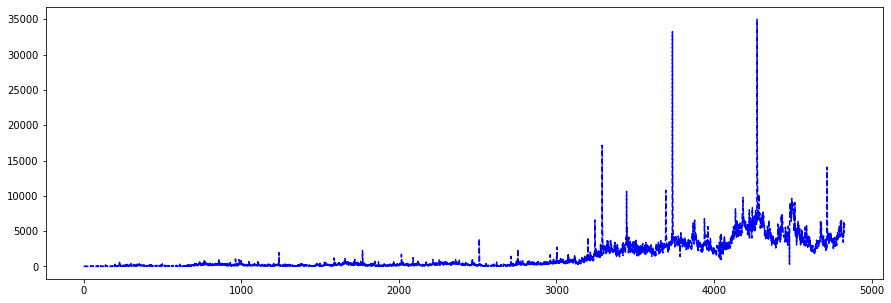

In [16]:
plt.figure(figsize=(15,5))
plt.plot(range(len(data_day)),data_day['Quantidade'], 'b--')
#plt.xlim(4000,4300)
plt.show()

In [18]:
time_steps = 365
test_size = 120

train_size = int(len(data_day_features)-(test_size))
train, test = data_day_features.iloc[0:train_size], data_day_features.iloc[(train_size-time_steps):len(data_day_features)]

print(len(train), len(test))

4710 485


In [48]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps),0].to_numpy()
        v = np.append(v,X.iloc[i + time_steps,1])#price
        v = np.append(v,X.iloc[i + time_steps,2])#d_semana
        v = np.append(v,X.iloc[i + time_steps,3])#d_mes
        v = np.append(v,X.iloc[i + time_steps,4])#d_ano
        Xs.append([v])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train, train['Quantidade'], time_steps)
X_test, y_test = create_dataset(test, test['Quantidade'], time_steps)



In [20]:
print(len(y_train),len(y_test))

4345 120


In [55]:
nsamples, nx, ny = X_train.shape
d2_xtrain_dataset = X_train.reshape((nsamples,nx*ny))
d2_xtrain_dataset


array([[3.42991988e-04, 9.60377566e-04, 1.71495994e-04, ...,
        7.72778088e-02, 4.33333333e-01, 5.31680441e-01],
       [9.60377566e-04, 1.71495994e-04, 0.00000000e+00, ...,
        7.74175517e-02, 4.66666667e-01, 5.34435262e-01],
       [1.71495994e-04, 0.00000000e+00, 1.37196795e-04, ...,
        7.75572946e-02, 5.00000000e-01, 5.37190083e-01],
       ...,
       [1.20469362e-01, 1.13626672e-01, 1.37280256e-01, ...,
        9.74846283e-01, 3.66666667e-01, 1.12947658e-01],
       [1.13626672e-01, 1.37280256e-01, 1.10667508e-01, ...,
        9.75544997e-01, 5.33333333e-01, 1.26721763e-01],
       [1.37280256e-01, 1.10667508e-01, 1.21424880e-01, ...,
        9.75684740e-01, 5.66666667e-01, 1.29476584e-01]])

In [59]:
parameters = [{
'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
'C': [1,2,3,300,500],
'max_iter': [1000,100000]}]

In [62]:
clf = GridSearchCV(
        SVR(), parameters, scoring='accuracy'
    )
x_fit = clf.fit(d2_xtrain_dataset, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 205, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

In [64]:
d2_xtrain_dataset

array([[3.42991988e-04, 9.60377566e-04, 1.71495994e-04, ...,
        7.72778088e-02, 4.33333333e-01, 5.31680441e-01],
       [9.60377566e-04, 1.71495994e-04, 0.00000000e+00, ...,
        7.74175517e-02, 4.66666667e-01, 5.34435262e-01],
       [1.71495994e-04, 0.00000000e+00, 1.37196795e-04, ...,
        7.75572946e-02, 5.00000000e-01, 5.37190083e-01],
       ...,
       [1.20469362e-01, 1.13626672e-01, 1.37280256e-01, ...,
        9.74846283e-01, 3.66666667e-01, 1.12947658e-01],
       [1.13626672e-01, 1.37280256e-01, 1.10667508e-01, ...,
        9.75544997e-01, 5.33333333e-01, 1.26721763e-01],
       [1.37280256e-01, 1.10667508e-01, 1.21424880e-01, ...,
        9.75684740e-01, 5.66666667e-01, 1.29476584e-01]])

In [21]:
def getModel():
    model = tf.keras.Sequential()
    
    # MLP    
    model.add(tf.keras.layers.Dense(300, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(tf.keras.layers.Dense(3000, activation="relu"))
    # model.add(tf.keras.layers.Dense(1000, activation="relu"))
    # model.add(tf.keras.layers.Dense(900, activation="relu"))
    # model.add(tf.keras.layers.Dense(300, activation="relu"))
    model.add(tf.keras.layers.Dense(100, activation="relu"))
    # model.add(tf.keras.layers.Dense(90, activation="relu"))
    model.add(tf.keras.layers.Dense(30, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="relu"))
    
    # Vanilla LSTM
    # model.add(tf.keras.layers.LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
        
    # Stacked LSTM
#     model.add(tf.keras.layers.LSTM(3000, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(tf.keras.layers.LSTM(1000, activation='relu', return_sequences=True))
#     model.add(tf.keras.layers.LSTM(300, activation='relu', return_sequences=True))
#     model.add(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True))
#     model.add(tf.keras.layers.LSTM(30, activation='relu', return_sequences=True))
#     model.add(tf.keras.layers.LSTM(10, activation='relu'))
    
    # Bidirectional LSTM
#     model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(tf.keras.layers.Dense(units=1,activation='softplus'))
    
    return model

In [22]:
model = getModel()

model.compile(
  loss='mean_squared_error',
  optimizer=tf.keras.optimizers.Adam(0.001)
)

In [26]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')]

callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, restore_best_weights=True))

history = model.fit(
    X_train, y_train,
    epochs=15, #1000
    batch_size=40, # 30
    validation_split=0.4,
    callbacks=callbacks,
    shuffle=False
)

Epoch 1/15
66/66 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0125 - lr: 1.0000e-09
Epoch 2/15
66/66 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0125 - lr: 1.0000e-09
Epoch 3/15
66/66 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0125 - lr: 1.0000e-09
Epoch 4/15
66/66 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0125 - lr: 1.0000e-09
Epoch 5/15
66/66 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0125 - lr: 1.0000e-09
Epoch 6/15
66/66 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0125 - lr: 1.0000e-09
Epoch 7/15
66/66 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0125 - lr: 1.0000e-09
Epoch 8/15
62/66 [===========================>..] - ETA: 0s - loss: 0.0082
Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
66/66 [==============================] -

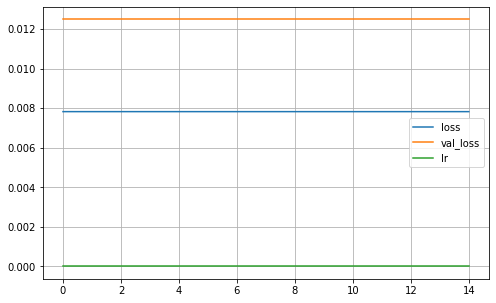

In [28]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Avaliando o modelo

In [29]:
# PREVENDO test_size DIAS

preds = []

base_teste = np.copy(X_test)

for i in range(len(base_teste)):
    
    y_pred = model.predict(np.array([base_teste[i]]))[0][0]

    preds.append(y_pred)

    for k in range(len(preds)):
        
        if k < time_steps:
            if(i<len(base_teste)-1):
                base_teste[i+1][0][(time_steps-1)-k] = preds[(len(preds)-1)-k]

# preds

In [30]:
base_teste[0].shape

(1, 369)

In [32]:
# APLICANDO O INVERSE SCALING NOS DADOS

dados_pred = {'Quantidade': preds,'d_semana': [0] * test_size,'d_mes': [0] * test_size,'d_ano': [0] * test_size}

data_day = data_day.append(pd.DataFrame(data=dados_pred))

if(transformar_features):
    data_day[feature_names] = scaler.inverse_transform(data_day[feature_names])
# feature_names = ['PU','Quantidade', 'Valor','d_semana','d_mes','d_ano']
df_dados_real_predito = data_day.tail(test_size*2)

dados_real = df_dados_real_predito [0:test_size]['Quantidade'].to_numpy()

dados_predito = df_dados_real_predito [test_size:test_size*2]['Quantidade'].to_numpy()


# dados_predito

In [33]:
df_real_predito = pd.DataFrame({'real':dados_real,'predito':dados_predito})

df_real_predito

,real,predito
0,1.430000e+08,0.200076
1,1.206679e+08,0.200076
2,9.839950e+07,0.200079
3,9.088725e+07,0.200087
4,1.039326e+08,0.200085
...,...,...
115,1.667238e+08,0.226366
116,2.082972e+08,0.226667
117,2.114740e+08,0.225243
118,2.000139e+08,0.227710


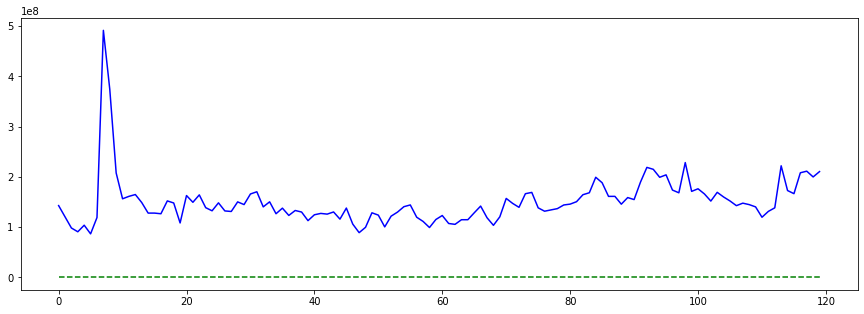

In [34]:
plt.figure(figsize=(15,5))
# plt.plot(range(len(y_train)),y_train, 'g--')
plt.plot(range(len(df_real_predito['predito'])),df_real_predito['predito'], 'g--')
plt.plot(range(len(df_real_predito['real'])),df_real_predito['real'], 'b')
# plt.xlim(0,200)
# plt.ylim(40,200)
plt.show()

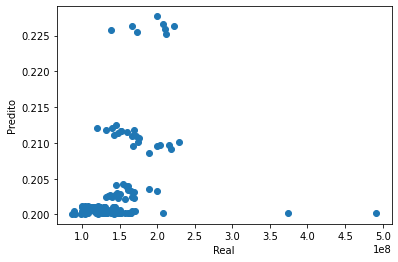

rmse= 158014031.449602
mae= 150436814.40895393
r2= -9.68305868463346


In [35]:
plt.scatter(df_real_predito['real'],df_real_predito['predito'])

plt.xlabel('Real')
plt.ylabel('Predito')

plt.show()
print('rmse=',sqrt(mean_squared_error(df_real_predito['real'].array,df_real_predito['predito'].array)))
print('mae=',mean_absolute_error(df_real_predito['real'].array,df_real_predito['predito'].array))
print('r2=',r2_score(df_real_predito['real'].array,df_real_predito['predito'].array))